In [2]:
!unzip "/content/dat.zip"


Archive:  /content/dat.zip
replace train/100_jpg.rf.f1b9d16649ab385e3691fa54301a3b61.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# 📦 Import libraries
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import box_iou

In [4]:
# 🧾 Dataset class
class MicroplasticDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.annotations = pd.read_csv(annotation_file)
        self.image_files = self.annotations["filename"].unique()
        self.transform = transform
        self.class_dict = {"Microplastic": 1}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, filename)
        image = Image.open(image_path).convert("RGB")

        boxes = []
        labels = []

        records = self.annotations[self.annotations["filename"] == filename]
        for _, row in records.iterrows():
            boxes.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
            labels.append(self.class_dict.get(row["class"], 0))

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)

        return image, target

In [5]:
# 📁 Path configuration
train_img_dir = "/content/train"
valid_img_dir = "/content/valid"
train_csv_path = os.path.join(train_img_dir, "_annotations.csv")
valid_csv_path = os.path.join(valid_img_dir, "_annotations.csv")


In [6]:
# 📚 Dataset & Dataloader
train_dataset = MicroplasticDetectionDataset(train_img_dir, train_csv_path)
valid_dataset = MicroplasticDetectionDataset(valid_img_dir, valid_csv_path)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [7]:
# 🧠 Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None, num_classes=2)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


In [8]:
# 🔁 Training + validation loop
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"🧠 Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

    # Validasi jumlah deteksi
    def evaluate_on_validation(model, data_loader, device, score_thresh=0.5):
        model.eval()
        total_preds, total_gts = 0, 0
        with torch.no_grad():
            for images, targets in data_loader:
                images = [img.to(device) for img in images]
                outputs = model(images)
                for output, target in zip(outputs, targets):
                    preds = output["boxes"][output["scores"] > score_thresh]
                    total_preds += len(preds)
                    total_gts += len(target["boxes"])
        model.train()
        return total_preds, total_gts

    val_preds, val_gts = evaluate_on_validation(model, valid_loader, device)
    print(f"🔍 Validation - Predictions: {val_preds}, Ground Truths: {val_gts}")

    # Save model
    torch.save(model.state_dict(), f"fasterrcnn_microplastic_epoch{epoch+1}.pth")
    print(f"✅ Model saved: fasterrcnn_microplastic_epoch{epoch+1}.pth")


🧠 Epoch 1/50 - Train Loss: 260.1599
🔍 Validation - Predictions: 971, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch1.pth
🧠 Epoch 2/50 - Train Loss: 270.9839
🔍 Validation - Predictions: 23, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch2.pth
🧠 Epoch 3/50 - Train Loss: 264.5480
🔍 Validation - Predictions: 867, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch3.pth
🧠 Epoch 4/50 - Train Loss: 256.8989
🔍 Validation - Predictions: 201, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch4.pth
🧠 Epoch 5/50 - Train Loss: 248.5344
🔍 Validation - Predictions: 2294, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch5.pth
🧠 Epoch 6/50 - Train Loss: 236.3606
🔍 Validation - Predictions: 1195, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch6.pth
🧠 Epoch 7/50 - Train Loss: 229.1123
🔍 Validation - Predictions: 1128, Ground Truths: 1701
✅ Model saved: fasterrcnn_microplastic_epoch7.pth
🧠 Epoch 8/50 - Train Loss

In [9]:
# 📊 Evaluasi detail per gambar
def compute_metrics_per_image(pred_boxes, gt_boxes, iou_thresh=0.5):
    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return 1, 1, 1, 1
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0, 0, 0, 0

    ious = box_iou(pred_boxes, gt_boxes)
    matched = set()
    tp = 0
    for i in range(len(pred_boxes)):
        max_iou = 0
        match_idx = -1
        for j in range(len(gt_boxes)):
            if j in matched:
                continue
            if ious[i, j] > max_iou:
                max_iou = ious[i, j]
                match_idx = j
        if max_iou >= iou_thresh:
            tp += 1
            matched.add(match_idx)

    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou = ious.mean().item() if ious.numel() > 0 else 0
    return precision, recall, f1, mean_iou


In [10]:
# 🧾 Load validation annotation
val_annotations = pd.read_csv(valid_csv_path)

In [11]:
# 📦 Evaluasi model
results = []
model.eval()

for fname in val_annotations["filename"].unique():
    image_path = os.path.join(valid_img_dir, fname)
    image = Image.open(image_path).convert("RGB")
    img_tensor = ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    pred_boxes = output["boxes"][output["scores"] > 0.5].cpu()
    pred_scores = output["scores"][output["scores"] > 0.5].cpu()
    gt = val_annotations[val_annotations["filename"] == fname]
    gt_boxes = torch.tensor(gt[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float)

    precision, recall, f1, iou = compute_metrics_per_image(pred_boxes, gt_boxes)

    results.append({
        "filename": fname,
        "actual_count": len(gt_boxes),
        "predicted_count": len(pred_boxes),
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_iou": iou
    })

In [12]:
# 💾 Simpan hasil evaluasi
results_df = pd.DataFrame(results)
results_df.to_csv("microplastic_detection_results.csv", index=False)
print("📁 Evaluation results saved to: microplastic_detection_results.csv")


📁 Evaluation results saved to: microplastic_detection_results.csv


In [13]:
# 📈 Rata-rata metrik keseluruhan
print("\n📊 Summary of Detection Metrics:")
print(f"Average Precision: {results_df['precision'].mean():.4f}")
print(f"Average Recall:    {results_df['recall'].mean():.4f}")
print(f"Average F1 Score:  {results_df['f1_score'].mean():.4f}")
print(f"Average IoU:       {results_df['mean_iou'].mean():.4f}")


📊 Summary of Detection Metrics:
Average Precision: 0.7530
Average Recall:    0.6402
Average F1 Score:  0.6703
Average IoU:       0.0948


In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import os
import torch
from PIL import Image
import pandas as pd
from torchvision.transforms import ToTensor

class MicroplasticCSVDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, csv_path, transforms=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transforms = transforms
        self.image_filenames = self.df["filename"].unique()

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        # Get all rows in the CSV that match this image
        records = self.df[self.df["filename"] == img_filename]

        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row["xmin"]
            ymin = row["ymin"]
            xmax = row["xmax"]
            ymax = row["ymax"]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(row["class"]) + 1)  # Background is 0, microplastic is 1

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = ToTensor()(img)

        return img, target

    def __len__(self):
        return len(self.image_filenames)


In [16]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Custom Dataset
class MicroplasticCSVDetectionDataset(Dataset):
    def __init__(self, img_dir, csv_path, transforms=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transforms = transforms
        self.image_filenames = self.df["filename"].unique()
        self.class_map = {"Microplastic": 1}  # Mapping string to int

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        records = self.df[self.df["filename"] == img_filename]

        boxes = []
        labels = []

        for _, row in records.iterrows():
            xmin = row["xmin"]
            ymin = row["ymin"]
            xmax = row["xmax"]
            ymax = row["ymax"]
            class_name = row["class"]
            class_id = self.class_map.get(class_name, 0)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_id)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = ToTensor()(img)

        return img, target

# Paths
train_dir = "/content/train"
valid_dir = "/content/valid"
train_csv = os.path.join(train_dir, "_annotations.csv")
valid_csv = os.path.join(valid_dir, "_annotations.csv")

# Datasets
train_dataset = MicroplasticCSVDetectionDataset(train_dir, train_csv)
valid_dataset = MicroplasticCSVDetectionDataset(valid_dir, valid_csv)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Model
model = fasterrcnn_resnet50_fpn(num_classes=2)  # 1 class + background
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Training
model.train()
for epoch in range(5):
    total_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Epoch 1: Loss = 297.5724
Epoch 2: Loss = 251.7567
Epoch 3: Loss = 235.2037
Epoch 4: Loss = 222.8381
Epoch 5: Loss = 213.1678


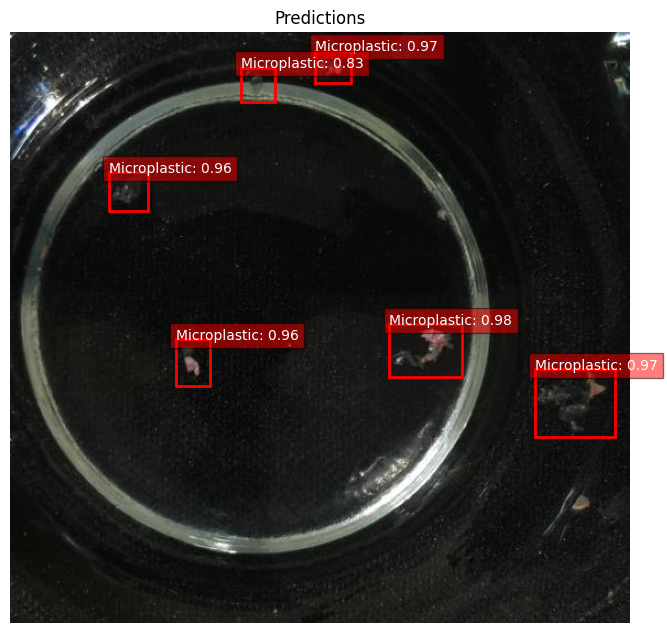

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Put model in eval mode
model.eval()

# Get a batch of validation data
images, targets = next(iter(valid_loader))
images = [img.to(device) for img in images]

# Inference
with torch.no_grad():
    predictions = model(images)

# Visualize predictions for 1 image
image = images[0].cpu()
pred = predictions[0]
boxes = pred['boxes'].cpu()
scores = pred['scores'].cpu()
labels = pred['labels'].cpu()

# Plot
plt.figure(figsize=(8, 8))
img = F.to_pil_image(image)
plt.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(x1, y1, f'Microplastic: {score:.2f}', color='white',
                 bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.title('Predictions')
plt.show()


In [18]:
torch.save(model.state_dict(), "fasterrcnn_microplastic.pth")


In [19]:
model.load_state_dict(torch.load("fasterrcnn_microplastic.pth"))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [20]:
from PIL import Image

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    return output

output = predict_image("/content/valid/a--27-_jpg.rf.8a800e6ec700f849fa4235fb736d6532.jpg")
print(output)


{'boxes': tensor([[269.7539, 209.0981, 357.7592, 284.5998],
        [159.0276, 243.2602, 250.0222, 334.4684],
        [268.7442, 420.6307, 365.0742, 505.4356],
        [ 63.0135, 451.4736, 135.3528, 515.0807],
        [  0.0000, 258.2369,  20.0345, 318.5766],
        [  0.0000, 263.1032,  10.8367, 308.8916],
        [480.0742,   0.0000, 498.6668,   7.8200],
        [176.3522, 441.8633, 201.2602, 462.8245],
        [ 10.5917, 260.9067,  23.7995, 312.6376],
        [119.6707, 123.3149, 141.0810, 143.7286],
        [478.7331,   1.5156, 500.2908,  11.0892],
        [  0.0000, 268.5860,  17.5322, 295.8865],
        [  0.0000, 281.9344,  16.7310, 304.7466],
        [481.0161,   0.0000, 492.8811,  11.3525],
        [487.2317,   0.0000, 499.1653,  12.0062],
        [122.1293, 126.3274, 134.0417, 141.2711],
        [473.6756,   0.0000, 504.1947,  14.5457],
        [140.4368, 209.3398, 373.1176, 321.6432],
        [  0.0000, 253.0180,  28.4472, 339.0551],
        [179.2267, 444.0795, 196.7235, 4

In [21]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch

# Load model
model = fasterrcnn_resnet50_fpn(num_classes=2)
model.load_state_dict(torch.load("fasterrcnn_microplastic.pth"))  # Update path if needed
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [22]:
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def predict_and_plot(image_path, threshold=0.5):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = ToTensor()(image).unsqueeze(0).to(device)

    # Run prediction
    with torch.no_grad():
        outputs = model(image_tensor)

    outputs = outputs[0]
    boxes = outputs['boxes'].cpu()
    scores = outputs['scores'].cpu()
    labels = outputs['labels'].cpu()

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, score in zip(boxes, scores):
        if score > threshold:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor='lime', facecolor='none'))
            ax.text(x1, y1, f'{score:.2f}', color='white',
                    bbox=dict(facecolor='lime', edgecolor='none', alpha=0.7))

    plt.axis("off")
    plt.title("Predicted Microplastics")
    plt.show()


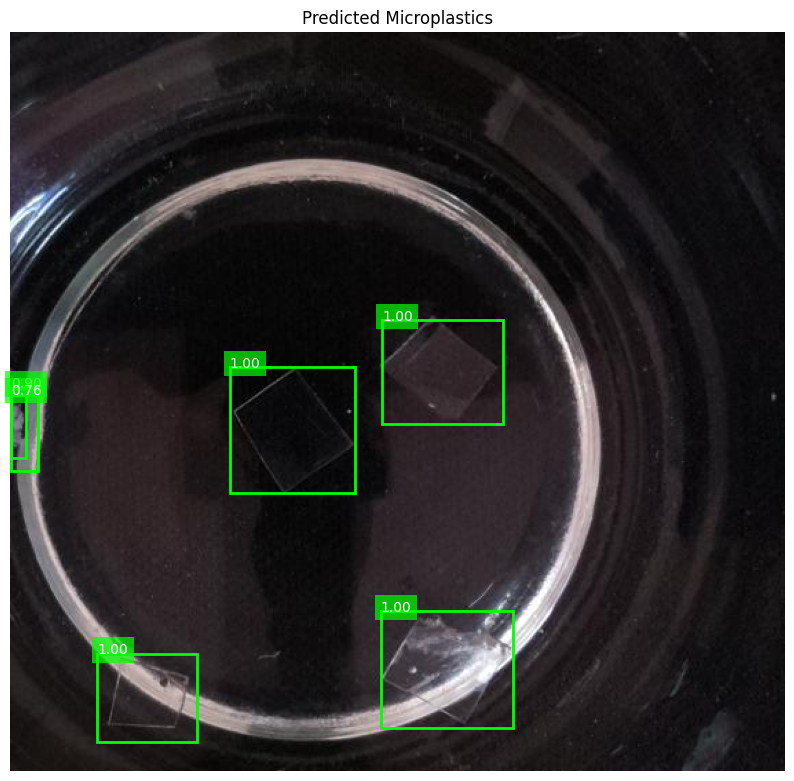

In [23]:
predict_and_plot("/content/valid/a--27-_jpg.rf.8a800e6ec700f849fa4235fb736d6532.jpg")


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision.transforms import ToTensor

def visualize_prediction_vs_actual(image_path, annotation_df, model, threshold=0.5):
    # Extract filename
    filename = image_path.split("/")[-1]

    # Load image
    image = Image.open(image_path).convert("RGB")
    image_tensor = ToTensor()(image).unsqueeze(0).to(device)

    # Predict with model
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)[0]

    pred_boxes = prediction['boxes'].cpu()
    pred_scores = prediction['scores'].cpu()
    pred_boxes = pred_boxes[pred_scores > threshold]

    # Get ground truth from CSV
    gt_boxes = annotation_df[annotation_df["filename"] == filename]

    # Plotting
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    # Draw ground truth (green)
    for _, row in gt_boxes.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    # Draw predictions (red)
    for box in pred_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Count
    actual_count = len(gt_boxes)
    predicted_count = len(pred_boxes)

    plt.title(f"Actual: {actual_count} vs Predicted: {predicted_count}", fontsize=16)
    plt.axis("off")
    plt.show()


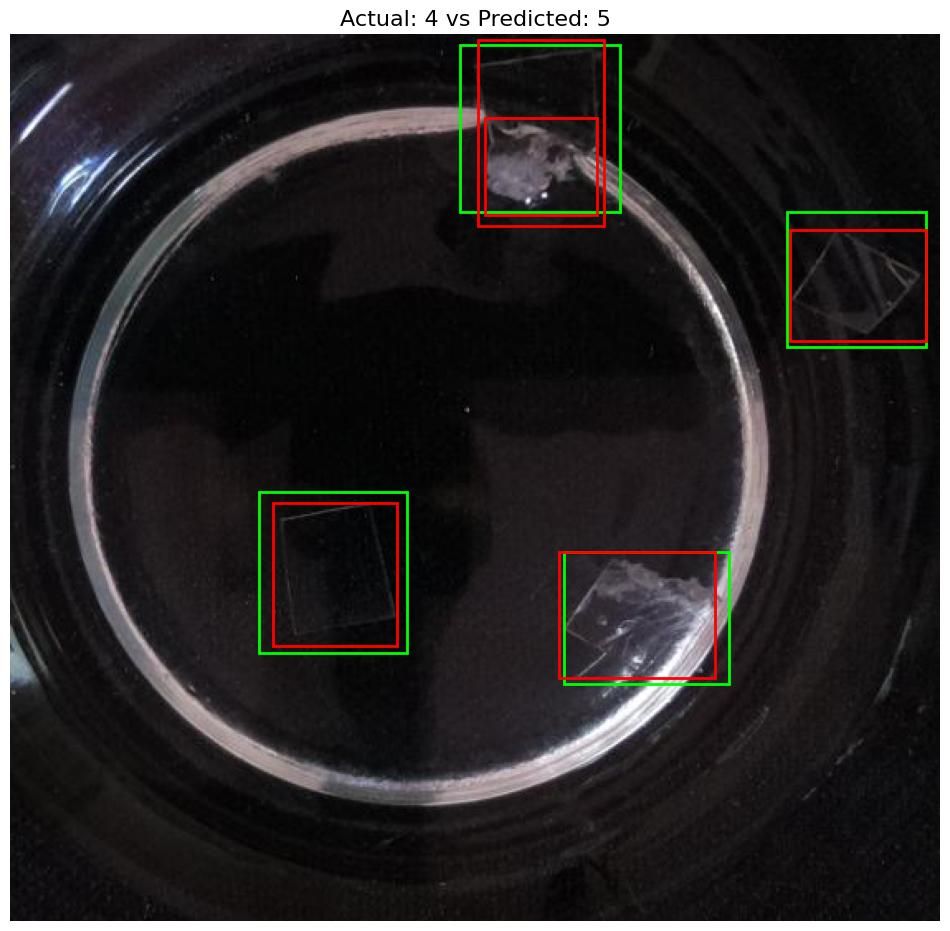

In [25]:
# Example: visualize for one image from validation set
image_path = "/content/valid/a--23-_jpg.rf.1ab5e302030f3bb3c08981ca42a8e631.jpg"
annotation_csv = pd.read_csv("/content/valid/_annotations.csv")

visualize_prediction_vs_actual(image_path, annotation_csv, model)


In [26]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.ops import box_iou

# Load your annotation CSV
valid_csv_path = "/content/valid/_annotations.csv"
annotation_df = pd.read_csv(valid_csv_path)

# Folder where your images are
valid_images_dir = "/content/valid"

# Get unique image filenames
image_files = annotation_df["filename"].unique()

# Evaluation function
def evaluate_detection(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return 1, 1, 1, 1
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0, 0, 0, 0

    ious = box_iou(pred_boxes, gt_boxes)
    matched_gt = set()
    tp = 0

    for i in range(len(pred_boxes)):
        max_iou = 0
        max_j = -1
        for j in range(len(gt_boxes)):
            if j in matched_gt:
                continue
            if ious[i, j] > max_iou:
                max_iou = ious[i, j]
                max_j = j
        if max_iou >= iou_threshold:
            tp += 1
            matched_gt.add(max_j)

    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou = ious.mean().item() if ious.numel() > 0 else 0
    return precision, recall, f1, mean_iou

# Run evaluation on all images
results = []
model.eval()

for filename in image_files:
    img_path = os.path.join(valid_images_dir, filename)
    image = Image.open(img_path).convert("RGB")
    img_tensor = ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Get predicted boxes
    pred_boxes = prediction['boxes'][prediction['scores'] > 0.5].cpu()

    # Get ground truth boxes for that image
    gt = annotation_df[annotation_df["filename"] == filename]
    gt_boxes = torch.tensor(gt[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float)

    precision, recall, f1, iou = evaluate_detection(pred_boxes, gt_boxes)

    results.append({
        "filename": filename,
        "actual_count": len(gt_boxes),
        "predicted_count": len(pred_boxes),
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mean_iou": iou
    })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("microplastic_detection_metrics.csv", index=False)
print("Evaluation saved to microplastic_detection_metrics.csv")


Evaluation saved to microplastic_detection_metrics.csv


In [27]:

import os
import torch
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.ops import box_iou

# Path to validation data
valid_csv_path = "/content/valid/_annotations.csv"
valid_images_dir = "/content/valid"
annotation_df = pd.read_csv(valid_csv_path)

image_files = annotation_df["filename"].unique()

# Setup
model.eval()
all_pred_boxes = []
all_gt_boxes = []

# Collect predictions and GT boxes from all images
for filename in image_files:
    img_path = os.path.join(valid_images_dir, filename)
    image = Image.open(img_path).convert("RGB")
    img_tensor = ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Filter predictions with confidence > 0.5
    pred_boxes = prediction['boxes'][prediction['scores'] > 0.5].cpu()
    all_pred_boxes.extend(pred_boxes)

    # Ground truth boxes
    gt = annotation_df[annotation_df["filename"] == filename]
    gt_boxes = torch.tensor(gt[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float)
    all_gt_boxes.extend(gt_boxes)

# Convert to tensors
all_pred_boxes = torch.stack(all_pred_boxes) if all_pred_boxes else torch.empty((0, 4))
all_gt_boxes = torch.stack(all_gt_boxes) if all_gt_boxes else torch.empty((0, 4))

# Evaluation function
def evaluate_all(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return 1, 1, 1, 1
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0, 0, 0, 0

    ious = box_iou(pred_boxes, gt_boxes)
    matched_gt = set()
    tp = 0

    for i in range(len(pred_boxes)):
        max_iou = 0
        max_j = -1
        for j in range(len(gt_boxes)):
            if j in matched_gt:
                continue
            if ious[i, j] > max_iou:
                max_iou = ious[i, j]
                max_j = j
        if max_iou >= iou_threshold:
            tp += 1
            matched_gt.add(max_j)

    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou = ious.mean().item() if ious.numel() > 0 else 0
    return precision, recall, f1, mean_iou

# Compute overall metrics
precision, recall, f1, mean_iou = evaluate_all(all_pred_boxes, all_gt_boxes)

# Show results
print(f"📈 Overall Validation Metrics:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")
print(f"   Mean IoU:  {mean_iou:.4f}")


📈 Overall Validation Metrics:
   Precision: 0.7726
   Recall:    0.7072
   F1 Score:  0.7385
   Mean IoU:  0.0039


🔍 Evaluating models:

➡ fasterrcnn_microplastic_epoch1.pth


   Precision=0.5541 | Recall=0.3163 | F1=0.4027
➡ fasterrcnn_microplastic_epoch10.pth


   Precision=0.5345 | Recall=0.6878 | F1=0.6015
➡ fasterrcnn_microplastic_epoch11.pth


   Precision=0.6277 | Recall=0.6255 | F1=0.6266
➡ fasterrcnn_microplastic_epoch12.pth


   Precision=0.5838 | Recall=0.6408 | F1=0.6110
➡ fasterrcnn_microplastic_epoch13.pth


   Precision=0.6587 | Recall=0.6149 | F1=0.6361
➡ fasterrcnn_microplastic_epoch14.pth


   Precision=0.6249 | Recall=0.6484 | F1=0.6365
➡ fasterrcnn_microplastic_epoch15.pth


   Precision=0.6754 | Recall=0.6079 | F1=0.6399
➡ fasterrcnn_microplastic_epoch16.pth


   Precision=0.6088 | Recall=0.6367 | F1=0.6224
➡ fasterrcnn_microplastic_epoch17.pth


   Precision=0.6170 | Recall=0.6432 | F1=0.6298
➡ fasterrcnn_microplastic_epoch18.pth


   Precision=0.6706 | Recall=0.6044 | F1=0.6357
➡ fasterrcnn_microplastic_epoch19.pth


   Precision=0.5648 | Recall=0.6584 | F1=0.6080
➡ fasterrcnn_microplastic_epoch2.pth


   Precision=0.5652 | Recall=0.0076 | F1=0.0151
➡ fasterrcnn_microplastic_epoch20.pth


   Precision=0.6334 | Recall=0.6002 | F1=0.6164
➡ fasterrcnn_microplastic_epoch21.pth


   Precision=0.6587 | Recall=0.6126 | F1=0.6348
➡ fasterrcnn_microplastic_epoch22.pth


   Precision=0.6892 | Recall=0.5867 | F1=0.6339
➡ fasterrcnn_microplastic_epoch23.pth


   Precision=0.5604 | Recall=0.6708 | F1=0.6106
➡ fasterrcnn_microplastic_epoch24.pth


   Precision=0.7265 | Recall=0.5591 | F1=0.6319
➡ fasterrcnn_microplastic_epoch25.pth


   Precision=0.7102 | Recall=0.5920 | F1=0.6457
➡ fasterrcnn_microplastic_epoch26.pth


   Precision=0.5916 | Recall=0.6549 | F1=0.6217
➡ fasterrcnn_microplastic_epoch27.pth


   Precision=0.6397 | Recall=0.6461 | F1=0.6429
➡ fasterrcnn_microplastic_epoch28.pth


   Precision=0.6600 | Recall=0.6255 | F1=0.6423
➡ fasterrcnn_microplastic_epoch29.pth


   Precision=0.7127 | Recall=0.5891 | F1=0.6450
➡ fasterrcnn_microplastic_epoch3.pth


   Precision=0.4510 | Recall=0.2299 | F1=0.3045
➡ fasterrcnn_microplastic_epoch30.pth


   Precision=0.7203 | Recall=0.5738 | F1=0.6387
➡ fasterrcnn_microplastic_epoch31.pth


   Precision=0.6931 | Recall=0.6361 | F1=0.6634
➡ fasterrcnn_microplastic_epoch32.pth


   Precision=0.7127 | Recall=0.5367 | F1=0.6123
➡ fasterrcnn_microplastic_epoch33.pth


   Precision=0.6979 | Recall=0.5920 | F1=0.6406
➡ fasterrcnn_microplastic_epoch34.pth


   Precision=0.6756 | Recall=0.6208 | F1=0.6471
➡ fasterrcnn_microplastic_epoch35.pth


   Precision=0.7071 | Recall=0.6173 | F1=0.6591
➡ fasterrcnn_microplastic_epoch36.pth


   Precision=0.6856 | Recall=0.6255 | F1=0.6542
➡ fasterrcnn_microplastic_epoch37.pth


   Precision=0.6858 | Recall=0.6108 | F1=0.6461
➡ fasterrcnn_microplastic_epoch38.pth


   Precision=0.6908 | Recall=0.5938 | F1=0.6386
➡ fasterrcnn_microplastic_epoch39.pth


   Precision=0.7340 | Recall=0.5791 | F1=0.6474
➡ fasterrcnn_microplastic_epoch4.pth


   Precision=0.0896 | Recall=0.0106 | F1=0.0189
➡ fasterrcnn_microplastic_epoch40.pth


   Precision=0.7461 | Recall=0.5873 | F1=0.6572
➡ fasterrcnn_microplastic_epoch41.pth


   Precision=0.7360 | Recall=0.6014 | F1=0.6619
➡ fasterrcnn_microplastic_epoch42.pth


   Precision=0.7327 | Recall=0.6026 | F1=0.6613
➡ fasterrcnn_microplastic_epoch43.pth


   Precision=0.7117 | Recall=0.6008 | F1=0.6516
➡ fasterrcnn_microplastic_epoch44.pth


   Precision=0.7159 | Recall=0.5985 | F1=0.6519
➡ fasterrcnn_microplastic_epoch45.pth


   Precision=0.7340 | Recall=0.5938 | F1=0.6565
➡ fasterrcnn_microplastic_epoch46.pth


   Precision=0.7154 | Recall=0.6132 | F1=0.6603
➡ fasterrcnn_microplastic_epoch47.pth


   Precision=0.7409 | Recall=0.5832 | F1=0.6526
➡ fasterrcnn_microplastic_epoch48.pth


   Precision=0.7319 | Recall=0.6114 | F1=0.6662
➡ fasterrcnn_microplastic_epoch49.pth


   Precision=0.7274 | Recall=0.6102 | F1=0.6637
➡ fasterrcnn_microplastic_epoch5.pth


   Precision=0.5002 | Recall=0.6749 | F1=0.5746
➡ fasterrcnn_microplastic_epoch50.pth


   Precision=0.7534 | Recall=0.5908 | F1=0.6623
➡ fasterrcnn_microplastic_epoch6.pth


   Precision=0.5490 | Recall=0.3857 | F1=0.4530
➡ fasterrcnn_microplastic_epoch7.pth


   Precision=0.5505 | Recall=0.3651 | F1=0.4390
➡ fasterrcnn_microplastic_epoch8.pth


   Precision=0.5863 | Recall=0.6390 | F1=0.6115
➡ fasterrcnn_microplastic_epoch9.pth


   Precision=0.7300 | Recall=0.3657 | F1=0.4873

✅ BEST MODEL FOUND
fasterrcnn_microplastic_epoch48.pth  | F1 = 0.6662390936017704


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

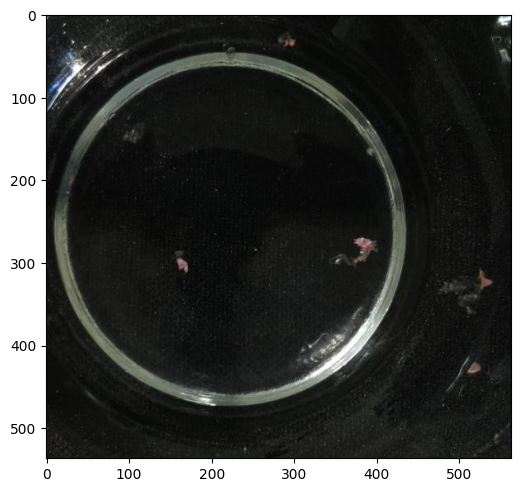

In [28]:
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# ---------------- CONFIG ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "."   # models are in root folder as shown
score_thresh = 0.5
iou_thresh = 0.5

# ---------------- IOU ----------------
def box_iou(a, b):
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (a[2]-a[0]) * (a[3]-a[1])
    areaB = (b[2]-b[0]) * (b[3]-b[1])
    return inter / (areaA + areaB - inter + 1e-6)

def compute_metrics(pred_boxes, gt_boxes):
    TP = FP = FN = 0
    matched = set()

    for pb in pred_boxes:
        found = False
        for i, gb in enumerate(gt_boxes):
            if i not in matched and box_iou(pb, gb) >= iou_thresh:
                TP += 1
                matched.add(i)
                found = True
                break
        if not found:
            FP += 1

    FN += len(gt_boxes) - len(matched)
    return TP, FP, FN

# ---------------- EVALUATION ----------------
def evaluate_model(model, loader):
    model.eval()
    TP = FP = FN = 0

    with torch.no_grad():
        for images, targets in tqdm(loader, leave=False):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, tgt in zip(outputs, targets):
                pred_boxes = out["boxes"][out["scores"] > score_thresh].cpu().numpy()
                gt_boxes = tgt["boxes"].cpu().numpy()

                tp, fp, fn = compute_metrics(pred_boxes, gt_boxes)
                TP += tp
                FP += fp
                FN += fn

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1

# ---------------- FIND ALL MODELS ----------------
model_files = sorted([
    f for f in os.listdir(model_dir)
    if f.startswith("fasterrcnn_microplastic_epoch") and f.endswith(".pth")
])

best_f1 = 0
best_model = None

print("🔍 Evaluating models:\n")

for mf in model_files:
    print(f"➡ {mf}")
    model = fasterrcnn_resnet50_fpn(weights=None, num_classes=2)
    model.load_state_dict(torch.load(mf, map_location=device))
    model.to(device)

    p, r, f1 = evaluate_model(model, valid_loader)
    print(f"   Precision={p:.4f} | Recall={r:.4f} | F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model = mf

print("\n✅ BEST MODEL FOUND")
print(best_model, " | F1 =", best_f1)

# ---------------- VISUAL CHECK ----------------
model = fasterrcnn_resnet50_fpn(weights=None, num_classes=2)
model.load_state_dict(torch.load(best_model, map_location=device))
model.to(device)
model.eval()

def show_predictions(img, out):
    img = img.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    for box, score in zip(out["boxes"], out["scores"]):
        if score > score_thresh:
            # Move box to CPU and convert to numpy before unpacking
            x1,y1,x2,y2 = box.cpu().numpy()
            plt.gca().add_patch(
                plt.Rectangle((x1,y1), x2-x1, y2-y1,
                              fill=False, edgecolor="red", linewidth=2)
            )
    plt.axis("off")
    plt.show()

with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for img, out in zip(images, outputs):
            show_predictions(img, out)
        break


### Upload a test image

Use the cell below to upload an image from your local machine. Once uploaded, the model will predict microplastics in the image.

Saving a--7-_jpg.rf.39b8597ed074d53daeaf5daf76fb41ac.jpg to a--7-_jpg.rf.39b8597ed074d53daeaf5daf76fb41ac.jpg
User uploaded file "a--7-_jpg.rf.39b8597ed074d53daeaf5daf76fb41ac.jpg" with length 28399 bytes


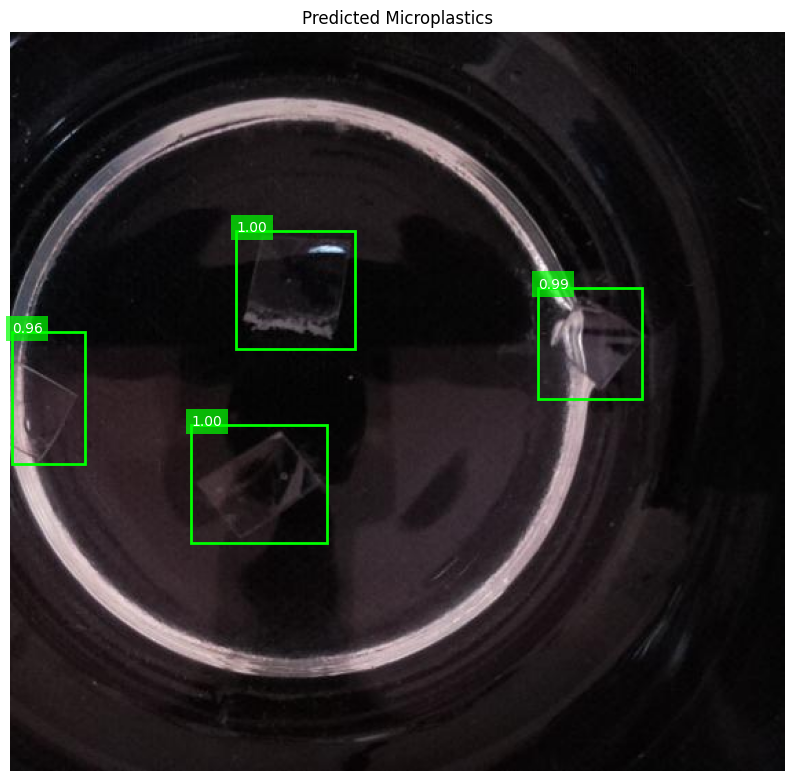

In [35]:
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Save the uploaded file to a temporary location or use its path directly
  with open(fn, 'wb') as f:
      f.write(uploaded[fn])
  uploaded_image_path = fn

# Call the predict_and_plot function with the path to the uploaded image
if 'uploaded_image_path' in locals():
    predict_and_plot(uploaded_image_path)